# Introduction

In this notebook we build our BiLSTM model for text classification. We first construct the data loaders, then implement train-validation splits. Then we initialize the word embeddings using GLOVE, then we define hyperparameters for our models. Then we train our models and evaluate them on the validation sets. We proceed with the best model configuration and create predictions with that for an independent test set that we prepared. We also visualized our word embeddings in 2-D using the T-SNE algorithm. Finally, we also tested our best model on the full, imbalanced dataset, as well as on the study/paper dataset. As a last step, we looked at misclassified cases, but we have not seen a strong systematic pattern in their text (except that lots of them were missing, coded as 'nann' and there are several duplicates, except for description since we removed duplicates in description).

# Importing packages

In [0]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)
import statsmodels as sm
import statsmodels.discrete.discrete_model as sm_models
import re 
import torch
import seaborn as sns
import random
import copy
from torchtext.vocab import GloVe, CharNGram, FastText
import torch.nn as nn
import torch.optim as optim
import spacy
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

#deal with tensors
import torch   

#handling text data
from torchtext import data


# Own function definitions

In [0]:
def confusion_matrix_builder(dataframe,true_colname,pred_colname):

  # Initialize confusion matrix
  conf_matrix = np.zeros((2,2))

  # Loop over matrix entries and calculate the values
  for i in range(0,len(dataframe)):
    if dataframe[true_colname].iloc[i] == 't' and dataframe[pred_colname].iloc[i] == 1:
      conf_matrix[1,1] += 1
    elif dataframe[true_colname].iloc[i] == 'f' and dataframe[pred_colname].iloc[i] == 0:
      conf_matrix[0,0] += 1
    elif dataframe[true_colname].iloc[i] == 't' and dataframe[pred_colname].iloc[i] == 0:
      conf_matrix[1,0] += 1
    else:
      conf_matrix[0,1] += 1

  return conf_matrix

In [0]:
def plot_confusion_matrix(cm, class_labels):
    """Pretty prints a confusion matrix as a figure

    Args:
        cm:  A confusion matrix for example
        [[245, 5 ], 
         [ 34, 245]]
         
        class_labels: The list of class labels to be plotted on x-y axis

    Rerturns:
        Just plots the confusion matrix.
    """
    
    df_cm = pd.DataFrame(cm, index = [i for i in class_labels],
                  columns = [i for i in class_labels])
    sns.set(font_scale=1)
    sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
    plt.rcParams["figure.figsize"] = (5,5)
    plt.xlabel("Predicted label")
    plt.ylabel("Real label")
    plt.show()

In [0]:
def reweight(pi,q1=0.5,r1=0.5):
    r0 = 1-r1
    q0 = 1-q1
    tot = pi*(q1/r1)+(1-pi)*(q0/r0)
    w = pi*(q1/r1)
    w /= tot
    return w

In [0]:
def get_auc(y, y_pred_probabilities, class_labels, column =1, plot = True):
    """Plots ROC AUC
    """
    fpr, tpr, _ = roc_curve(y, y_pred_probabilities,drop_intermediate = False)
    #roc_auc = roc_auc_score(y_true=y, y_score=y_pred_probabilities[:,1])
    roc_auc = roc_auc_score(y_true=y, y_score=y_pred_probabilities)
    print ("AUC: ", roc_auc)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for the BiLSTM model on the {} test set'.format(current_text_var))
    plt.legend(loc="lower right")
    plt.show()

# Modelling workflow

## Data loading

In [0]:
#Reproducing same results
SEED = 2019

#Torch
torch.manual_seed(SEED)

#Cuda algorithms
torch.backends.cudnn.deterministic = True

In [0]:
#define tokenizers
TEXT = data.Field(tokenize='spacy',batch_first=True,include_lengths=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)

In [0]:
# Define current variable to be used

current_text_var = 'requirements'


In [51]:
# Data loading
fields = [(None, None),('label', LABEL), ('text',TEXT)]
#fields = [('label', LABEL),('text',TEXT)]

#url = 'https://github.com/k-amini/NLP_RNN/blob/master/train(1).csv'

#loading custom dataset
training_data=data.TabularDataset(path = 'train_{}.csv'.format(current_text_var),format = 'csv',fields = fields,skip_header = True)
#training_data=data.TabularDataset(path = 'study_{}.csv'.format(current_text_var),format = 'csv',fields = fields,skip_header = True)

#print preprocessed text
print(vars(training_data.examples[0]))

{'label': 'f', 'text': ['nann']}


## Train-validation split

In [0]:
# Train-validation split
train_data, valid_data = training_data.split(split_ratio=0.3, random_state = random.seed(SEED))

## Word embedding, vocabulary building

In [53]:

#initialize glove embeddings
TEXT.build_vocab(train_data,min_freq=3,vectors = "glove.6B.100d") #glove.6B.100d or fasttext.en.300d or glove.twitter.27B.50d 
#TEXT.build_vocab(train_data,min_freq=3,vectors = FastText(language='en'))
#TEXT.build_vocab(train_data,min_freq=3,vectors = CharNGram())
#TEXT.build_vocab(train_data,min_freq=3,vectors = "fasttext.simple.300d")

# https://github.com/pytorch/text/blob/master/torchtext/vocab.py List of all pretrained word embeddings
# Only Glove-s work!!!
LABEL.build_vocab(train_data)

#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))  

#Word dictionary
print(TEXT.vocab.stoi)

Size of TEXT vocabulary: 1680
Size of LABEL vocabulary: 2
[('and', 1849), (',', 1844), ('.', 1265), ('to', 1035), ('of', 774), ('in', 767), ('a', 725), ('experience', 719), ('with', 580), ('-', 578)]
defaultdict(<function _default_unk_index at 0x7fc1eed83268>, {'<unk>': 0, '<pad>': 1, 'and': 2, ',': 3, '.': 4, 'to': 5, 'of': 6, 'in': 7, 'a': 8, 'experience': 9, 'with': 10, '-': 11, 'the': 12, 'or': 13, 'skills': 14, '/': 15, ':': 16, 'ability': 17, 'for': 18, 'be': 19, 'work': 20, '(': 21, ')': 22, 'knowledge': 23, 'you': 24, 'years': 25, 'as': 26, 'on': 27, 'is': 28, 'have': 29, 'must': 30, 'strong': 31, 'required': 32, 'an': 33, 'communication': 34, 'excellent': 35, 'team': 36, 'working': 37, 'management': 38, '•': 39, 'design': 40, 'environment': 41, 'are': 42, 'development': 43, 'at': 44, ';': 45, 'able': 46, 'degree': 47, 'high': 48, 'web': 49, 'written': 50, 'understanding': 51, 'requirements': 52, 'plus': 53, 'software': 54, '+': 55, 'data': 56, 'good': 57, 'we': 58, 'preferred'

## Model architecture

In [0]:
#check whether cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

#set batch size
BATCH_SIZE = 64

#Load an iterator
train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_data, valid_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

In [0]:
import torch.nn as nn

class classifier(nn.Module):
    
    #define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout):
        
        #Constructor
        super().__init__()          
        
        #embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm layer
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        
        #dense layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        #activation function
        self.act = nn.Sigmoid()
        
    def forward(self, text, text_lengths):
        
        embedded = self.embedding(text)
      
        #packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)
        
        packed_output, (hidden, cell) = self.lstm(packed_embedded)

        
        #concat the final forward and backward hidden state
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
                
        #hidden = [batch size, hid dim * num directions]
        dense_outputs=self.fc(hidden)

        #Final activation function
        outputs=self.act(dense_outputs)
        
        return outputs

## Hyperparameters

In [0]:
#define hyperparameters
size_of_vocab = len(TEXT.vocab)
embedding_dim = 100
num_hidden_nodes = 32
num_output_nodes = 1
num_layers = 3
bidirection = True
dropout = 0.2

#instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes,num_output_nodes, num_layers, 
                   bidirectional = True, dropout = dropout)

In [57]:
#architecture
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

#Initialize the pretrained embedding
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

print(pretrained_embeddings.shape)

classifier(
  (embedding): Embedding(1680, 100)
  (lstm): LSTM(100, 32, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (act): Sigmoid()
)
The model has 252,545 trainable parameters
torch.Size([1680, 100])


## Optimization and loss function configuration

In [0]:
import torch.optim as optim

#define optimizer and loss
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

#define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(preds)
    
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
#push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [0]:
def train(model, iterator, optimizer, criterion):
    
    #initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    #set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        #resets the gradients after every batch
        optimizer.zero_grad()   
        
        #retrieve text and no. of words   
        text, text_lengths = batch.text 
        
        #convert to 1D tensor
        predictions = model(text, text_lengths).squeeze()
        
        #compute the loss
        loss = criterion(predictions, batch.label)        
        
        #compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label)   
        
        #backpropage the loss and compute the gradients
        loss.backward()       
        
        #update the weights
        optimizer.step()      
        
        #loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
def evaluate(model, iterator, criterion):
    
    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    #deactivating dropout layers
    model.eval()
    
    #deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            #retrieve text and no. of words
            
            text, text_lengths = batch.text
            
            #convert to 1d tensor
            predictions = model(text, text_lengths).squeeze()
            
            #compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            
            #keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

## Training and evaluation

In [0]:
# Fit initial validation loss to infinity
best_valid_loss = float('inf')


### Model version 1

3 hidden layers with 32 nodes in each and a dropout rate of 25%



In [62]:
# Define number of epochs, 20 seemed enough for the model to converge
N_EPOCHS = 20

# Initialize lists to hold the results
train_losses = []
val_losses = []

train_accs = []
val_accs = []

for epoch in range(N_EPOCHS):
     
    #train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    #evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    val_losses.append(valid_loss)
    val_accs.append(valid_acc)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
        model_best = copy.deepcopy(model)
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

	Train Loss: 0.670 | Train Acc: 68.95%
	 Val. Loss: 0.643 |  Val. Acc: 71.21%
	Train Loss: 0.639 | Train Acc: 68.95%
	 Val. Loss: 0.602 |  Val. Acc: 71.21%
	Train Loss: 0.635 | Train Acc: 68.95%
	 Val. Loss: 0.591 |  Val. Acc: 71.21%
	Train Loss: 0.612 | Train Acc: 68.95%
	 Val. Loss: 0.594 |  Val. Acc: 71.21%
	Train Loss: 0.597 | Train Acc: 68.95%
	 Val. Loss: 0.587 |  Val. Acc: 71.21%
	Train Loss: 0.583 | Train Acc: 68.95%
	 Val. Loss: 0.576 |  Val. Acc: 71.21%
	Train Loss: 0.548 | Train Acc: 75.20%
	 Val. Loss: 0.564 |  Val. Acc: 71.44%
	Train Loss: 0.524 | Train Acc: 75.98%
	 Val. Loss: 0.570 |  Val. Acc: 72.40%
	Train Loss: 0.472 | Train Acc: 78.91%
	 Val. Loss: 0.548 |  Val. Acc: 72.17%
	Train Loss: 0.430 | Train Acc: 79.69%
	 Val. Loss: 0.565 |  Val. Acc: 71.25%
	Train Loss: 0.367 | Train Acc: 84.77%
	 Val. Loss: 0.560 |  Val. Acc: 71.90%
	Train Loss: 0.343 | Train Acc: 88.28%
	 Val. Loss: 0.607 |  Val. Acc: 69.92%
	Train Loss: 0.276 | Train Acc: 91.80%
	 Val. Loss: 0.623 |  Val

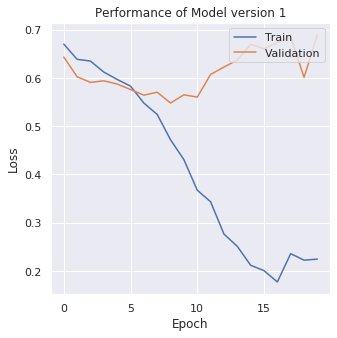

In [63]:
plt.plot(np.arange(N_EPOCHS),train_losses,label="Train")
plt.plot(np.arange(N_EPOCHS),val_losses,label="Validation")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Performance of Model version 1")
plt.legend(loc="upper right")
plt.show()

### Model version 2

4 hidden layers, with 16 hidden node in each and a dropout of 25%

In [0]:
#define hyperparameters
size_of_vocab = len(TEXT.vocab)
embedding_dim = 100 
num_hidden_nodes = 16
num_output_nodes = 1
num_layers = 4
bidirection = True
dropout = 0.25

#instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes,num_output_nodes, num_layers, 
                   bidirectional = True, dropout = dropout)

# Append weights from pretrained embedding
model.embedding.weight.data.copy_(pretrained_embeddings)

#define optimizer and loss
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

#push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [65]:
N_EPOCHS = 20

# Initialize lists to hold the results
train_losses = []
val_losses = []

train_accs = []
val_accs = []

for epoch in range(N_EPOCHS):
     
    #train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    #evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    val_losses.append(valid_loss)
    val_accs.append(valid_acc)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
        model_best = copy.deepcopy(model)
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

	Train Loss: 0.708 | Train Acc: 32.42%
	 Val. Loss: 0.693 |  Val. Acc: 67.68%
	Train Loss: 0.684 | Train Acc: 60.35%
	 Val. Loss: 0.664 |  Val. Acc: 67.07%
	Train Loss: 0.661 | Train Acc: 61.52%
	 Val. Loss: 0.631 |  Val. Acc: 71.21%
	Train Loss: 0.637 | Train Acc: 68.36%
	 Val. Loss: 0.607 |  Val. Acc: 71.21%
	Train Loss: 0.625 | Train Acc: 68.95%
	 Val. Loss: 0.597 |  Val. Acc: 71.21%
	Train Loss: 0.627 | Train Acc: 68.95%
	 Val. Loss: 0.593 |  Val. Acc: 71.21%
	Train Loss: 0.624 | Train Acc: 68.95%
	 Val. Loss: 0.593 |  Val. Acc: 71.21%
	Train Loss: 0.615 | Train Acc: 68.95%
	 Val. Loss: 0.594 |  Val. Acc: 71.21%
	Train Loss: 0.600 | Train Acc: 68.95%
	 Val. Loss: 0.585 |  Val. Acc: 71.21%
	Train Loss: 0.571 | Train Acc: 68.95%
	 Val. Loss: 0.573 |  Val. Acc: 71.21%
	Train Loss: 0.519 | Train Acc: 68.95%
	 Val. Loss: 0.568 |  Val. Acc: 71.53%
	Train Loss: 0.465 | Train Acc: 80.47%
	 Val. Loss: 0.554 |  Val. Acc: 71.36%
	Train Loss: 0.426 | Train Acc: 85.74%
	 Val. Loss: 0.566 |  Val

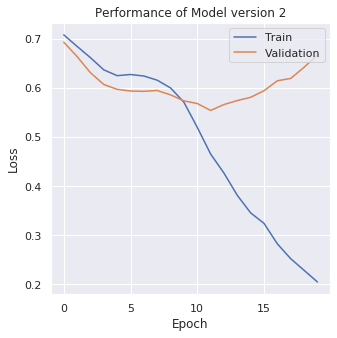

In [66]:
plt.plot(np.arange(N_EPOCHS),train_losses,label="Train")
plt.plot(np.arange(N_EPOCHS),val_losses,label="Validation")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Performance of Model version 2")
plt.legend(loc="upper right")
plt.show()

### Model version 3

4 hidden layers with 64 nodes in each with a 0.3 dropout rate and 20 epochs.

In [0]:
#define hyperparameters
size_of_vocab = len(TEXT.vocab)
embedding_dim = 100 
num_hidden_nodes = 64
num_output_nodes = 1
num_layers = 4
bidirection = True
dropout = 0.3

#instantiate the model
model3 = classifier(size_of_vocab, embedding_dim, num_hidden_nodes,num_output_nodes, num_layers, 
                   bidirectional = True, dropout = dropout)

# Append weights from pretrained embedding
model3.embedding.weight.data.copy_(pretrained_embeddings)

#define optimizer and loss
optimizer = optim.Adam(model3.parameters())
criterion = nn.BCELoss()

#push to cuda if available
model3 = model3.to(device)
criterion = criterion.to(device)

In [68]:
N_EPOCHS = 20

# Initialize lists to hold the results
train_losses = []
val_losses = []

train_accs = []
val_accs = []

for epoch in range(N_EPOCHS):
     
    #train the model
    train_loss, train_acc = train(model3, train_iterator, optimizer, criterion)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    #evaluate the model
    valid_loss, valid_acc = evaluate(model3, valid_iterator, criterion)
    val_losses.append(valid_loss)
    val_accs.append(valid_acc)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model3.state_dict(), 'saved_weights.pt')
        model_best = copy.deepcopy(model3)
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

	Train Loss: 0.683 | Train Acc: 54.88%
	 Val. Loss: 0.626 |  Val. Acc: 71.21%
	Train Loss: 0.630 | Train Acc: 68.95%
	 Val. Loss: 0.591 |  Val. Acc: 71.21%
	Train Loss: 0.620 | Train Acc: 68.95%
	 Val. Loss: 0.593 |  Val. Acc: 71.21%
	Train Loss: 0.621 | Train Acc: 68.95%
	 Val. Loss: 0.591 |  Val. Acc: 71.21%
	Train Loss: 0.590 | Train Acc: 68.95%
	 Val. Loss: 0.604 |  Val. Acc: 71.21%
	Train Loss: 0.577 | Train Acc: 75.39%
	 Val. Loss: 0.612 |  Val. Acc: 71.49%
	Train Loss: 0.565 | Train Acc: 75.98%
	 Val. Loss: 0.581 |  Val. Acc: 71.44%
	Train Loss: 0.520 | Train Acc: 76.95%
	 Val. Loss: 0.570 |  Val. Acc: 71.31%
	Train Loss: 0.476 | Train Acc: 81.64%
	 Val. Loss: 0.556 |  Val. Acc: 73.06%
	Train Loss: 0.411 | Train Acc: 83.20%
	 Val. Loss: 0.558 |  Val. Acc: 72.82%
	Train Loss: 0.341 | Train Acc: 85.74%
	 Val. Loss: 0.610 |  Val. Acc: 70.70%
	Train Loss: 0.289 | Train Acc: 88.48%
	 Val. Loss: 0.683 |  Val. Acc: 68.74%
	Train Loss: 0.279 | Train Acc: 89.65%
	 Val. Loss: 0.932 |  Val

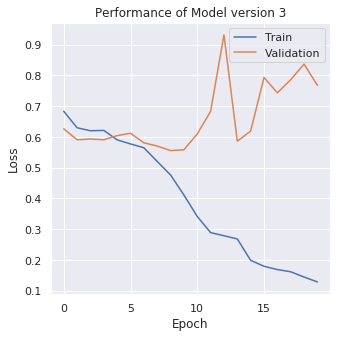

In [69]:
plt.plot(np.arange(N_EPOCHS),train_losses,label="Train")
plt.plot(np.arange(N_EPOCHS),val_losses,label="Validation")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Performance of Model version 3")
plt.legend(loc="upper right")
plt.show()

## Prediction

In [0]:
#load weights
path='saved_weights.pt'
model_best.load_state_dict(torch.load(path));
model_best.eval();

#import spacy
nlp = spacy.load('en')

def predict(model, sentence):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]  #tokenize the sentence 
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]          #convert to integer sequence
    length = [len(indexed)]                                    #compute no. of words
    tensor = torch.LongTensor(indexed).to(device)              #convert to tensor
    tensor = tensor.unsqueeze(1).T                             #reshape in form of batch,no. of words
    length_tensor = torch.LongTensor(length)                   #convert to tensor
    prediction = model(tensor, length_tensor)                  #prediction 
    return prediction.item()

### Small, "hand-made examples" (own input text)

In [71]:
# LinkedIn template example
pred1 = predict(model, "At [CompanyX], our financial systems are the engine that enables us to power forward. We are searching for a qualified accountant to help keep our [client’s] finances meticulously correct and powerfully informative. The accountant will have both an immediate and lasting impact on all company operations, helping us to strategize savings, perform impactful audits, furnish leadership with crucial information, and (ultimately) grow our financial position. [CompanyX] is committed to serving both customers and employees in the best way possible, and it starts with keeping our own finances accurately reported, meticulously organized, and vitally strategic.")
print("Probability of fraudulent job advertisement based on the text: {}".format(pred1))

# LinkedIn true example
pred2 = predict(model,'Working at Citi Finance takes you to the heart of the world-class financial institution, active in more than 160 countries, covering a wide range of activities from traditional banking to investment banking, where you will find creative, visionary and entrepreneurial thinkers like you. Our mission is to provide insight and analytics to senior management, business management and regulators in more than 50 countries across Europe, the Middle East and Africa')
print("Probability of fraudulent job advertisement based on the text: {}".format(pred2))

# Fraud example
pred3 = predict(model, "We have several openings available in this area offering a competitive income averaging about R2,500 per week. We are seeking only, honest, self-motivated people with desire to work in the home typing and data entry field, from the comfort of their own homes. No experience is needed. . If you fit the above description and meet the requirements, please apply at EMAIL_3b3253aa3e1aa29ecb8bffbcc2811a9d106482ed5d0aa334ca98e74289e2c3af")
print("Probability of fraudulent job advertisement based on the text: {}".format(pred3))

# Fraud example
pred4 = predict(model, "are you finding it harder to work for a boss? have you always wanted a better work / life balance? do you want to receive the reward you deserve for the effort you put in? this is a fantastic opportunity that allows you to start part time or full time. the opportunity simple 3 step system no previous experience necessary because we will teach you how to use our proven system earn immediate income unlimited income potential highly profitable work from home in your own business take the 5 minutes that will change your life. for further information visit")
print("Probability of fraudulent job advertisement based on the text: {}".format(pred4))

# Fraud example
pred5 = predict(model, "Sales executive")
print("Probability of fraudulent job advertisement based on the text: {}".format(pred5))


Probability of fraudulent job advertisement based on the text: 0.6291226148605347
Probability of fraudulent job advertisement based on the text: 0.21091148257255554
Probability of fraudulent job advertisement based on the text: 0.9091500043869019
Probability of fraudulent job advertisement based on the text: 0.01857990212738514
Probability of fraudulent job advertisement based on the text: 0.6047338843345642


# Evaluation on the independent test set

In [72]:
# Load in test set
url = "https://raw.githubusercontent.com/k-amini/NLP_RNN/master/clean_deduplicated_data/test_{}.csv".format(current_text_var)
data_test = pd.read_csv(url)
print("Datafile loaded!")
#data = data.sample(frac = 0.15)

# Predict probabilities
data_test['pred_proba'] = [predict(model, str(i)) for i in data_test[current_text_var]]

Datafile loaded!


In [0]:
# Sample and population probabilities
q1 = 155/500
r1 = 586/2000

# Reweight class prediction probabilities
data_test['pred_rew_proba'] = data_test['pred_proba'].apply(reweight,args=(q1,r1))
# Classification (here we set the threshold to be 0.5)
data_test['pred_rew'] = [1 if data_test['pred_rew_proba'].iloc[i]>0.5 else 0 for i in range(0,len(data_test))]

In [74]:
# Inspect results
print(data_test.head())
data_test.shape
len(data_test)

   Unnamed: 0 fraudulent  ... pred_rew_proba  pred_rew
0        3438          t  ...       0.496204         0
1        7419          f  ...       0.023803         0
2        2969          t  ...       0.039214         0
3        8027          t  ...       0.213913         0
4        8219          f  ...       0.496204         0

[5 rows x 6 columns]


500

In [75]:
# Create confusion matrix
conf_matrix = confusion_matrix_builder(dataframe=data_test,
                                       true_colname='fraudulent',
                                       pred_colname='pred_rew')
# Print results
print(conf_matrix)

[[297.  48.]
 [ 93.  62.]]


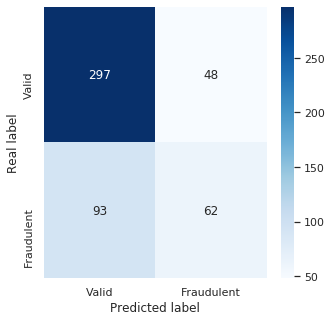

In [76]:
plot_confusion_matrix(conf_matrix, class_labels=['Valid','Fraudulent'])

ROC-AUC score and curve

In [0]:
# Convert target variable to numeric
data_test['fraudulent'] = [1 if i=='t' else 0 for i in data_test['fraudulent']]

In [78]:
data_test.fraudulent.value_counts()


0    345
1    155
Name: fraudulent, dtype: int64

AUC:  0.6955960729312762


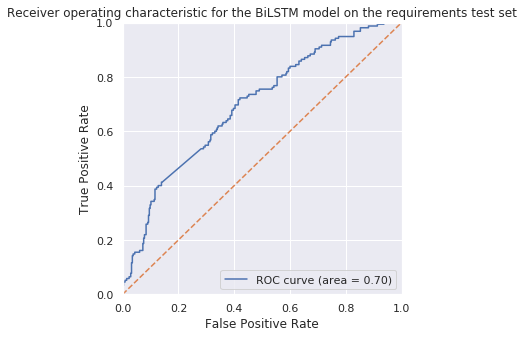

In [79]:
get_auc(y=data_test['fraudulent'], y_pred_probabilities=data_test['pred_rew_proba'],
        class_labels=['Valid','Fraudulent'],
        column =1, plot = True)

Accuracy

In [80]:
# Get accuracy
acc_score = accuracy_score(data_test['fraudulent'],data_test['pred_rew'])
print("Accuracy score: {}".format(acc_score))

Accuracy score: 0.718


#### Export predictions

In [0]:
data_test.to_csv('test_preds_bilstm_{}.csv'.format(current_text_var))

# T-SNE of word embeddings

In [81]:
## Get word embedding vectors from the model
temp_embed = model.embedding
temp_weights = temp_embed.weight
print(temp_weights.shape)

torch.Size([1680, 100])


In [0]:
# Initialize T-SNE model
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)

# Convert tensor to numpy array
temp_weights = temp_weights.data.cpu().numpy()

# Fit the model
word_embed_vec2d = tsne_model.fit_transform(temp_weights)

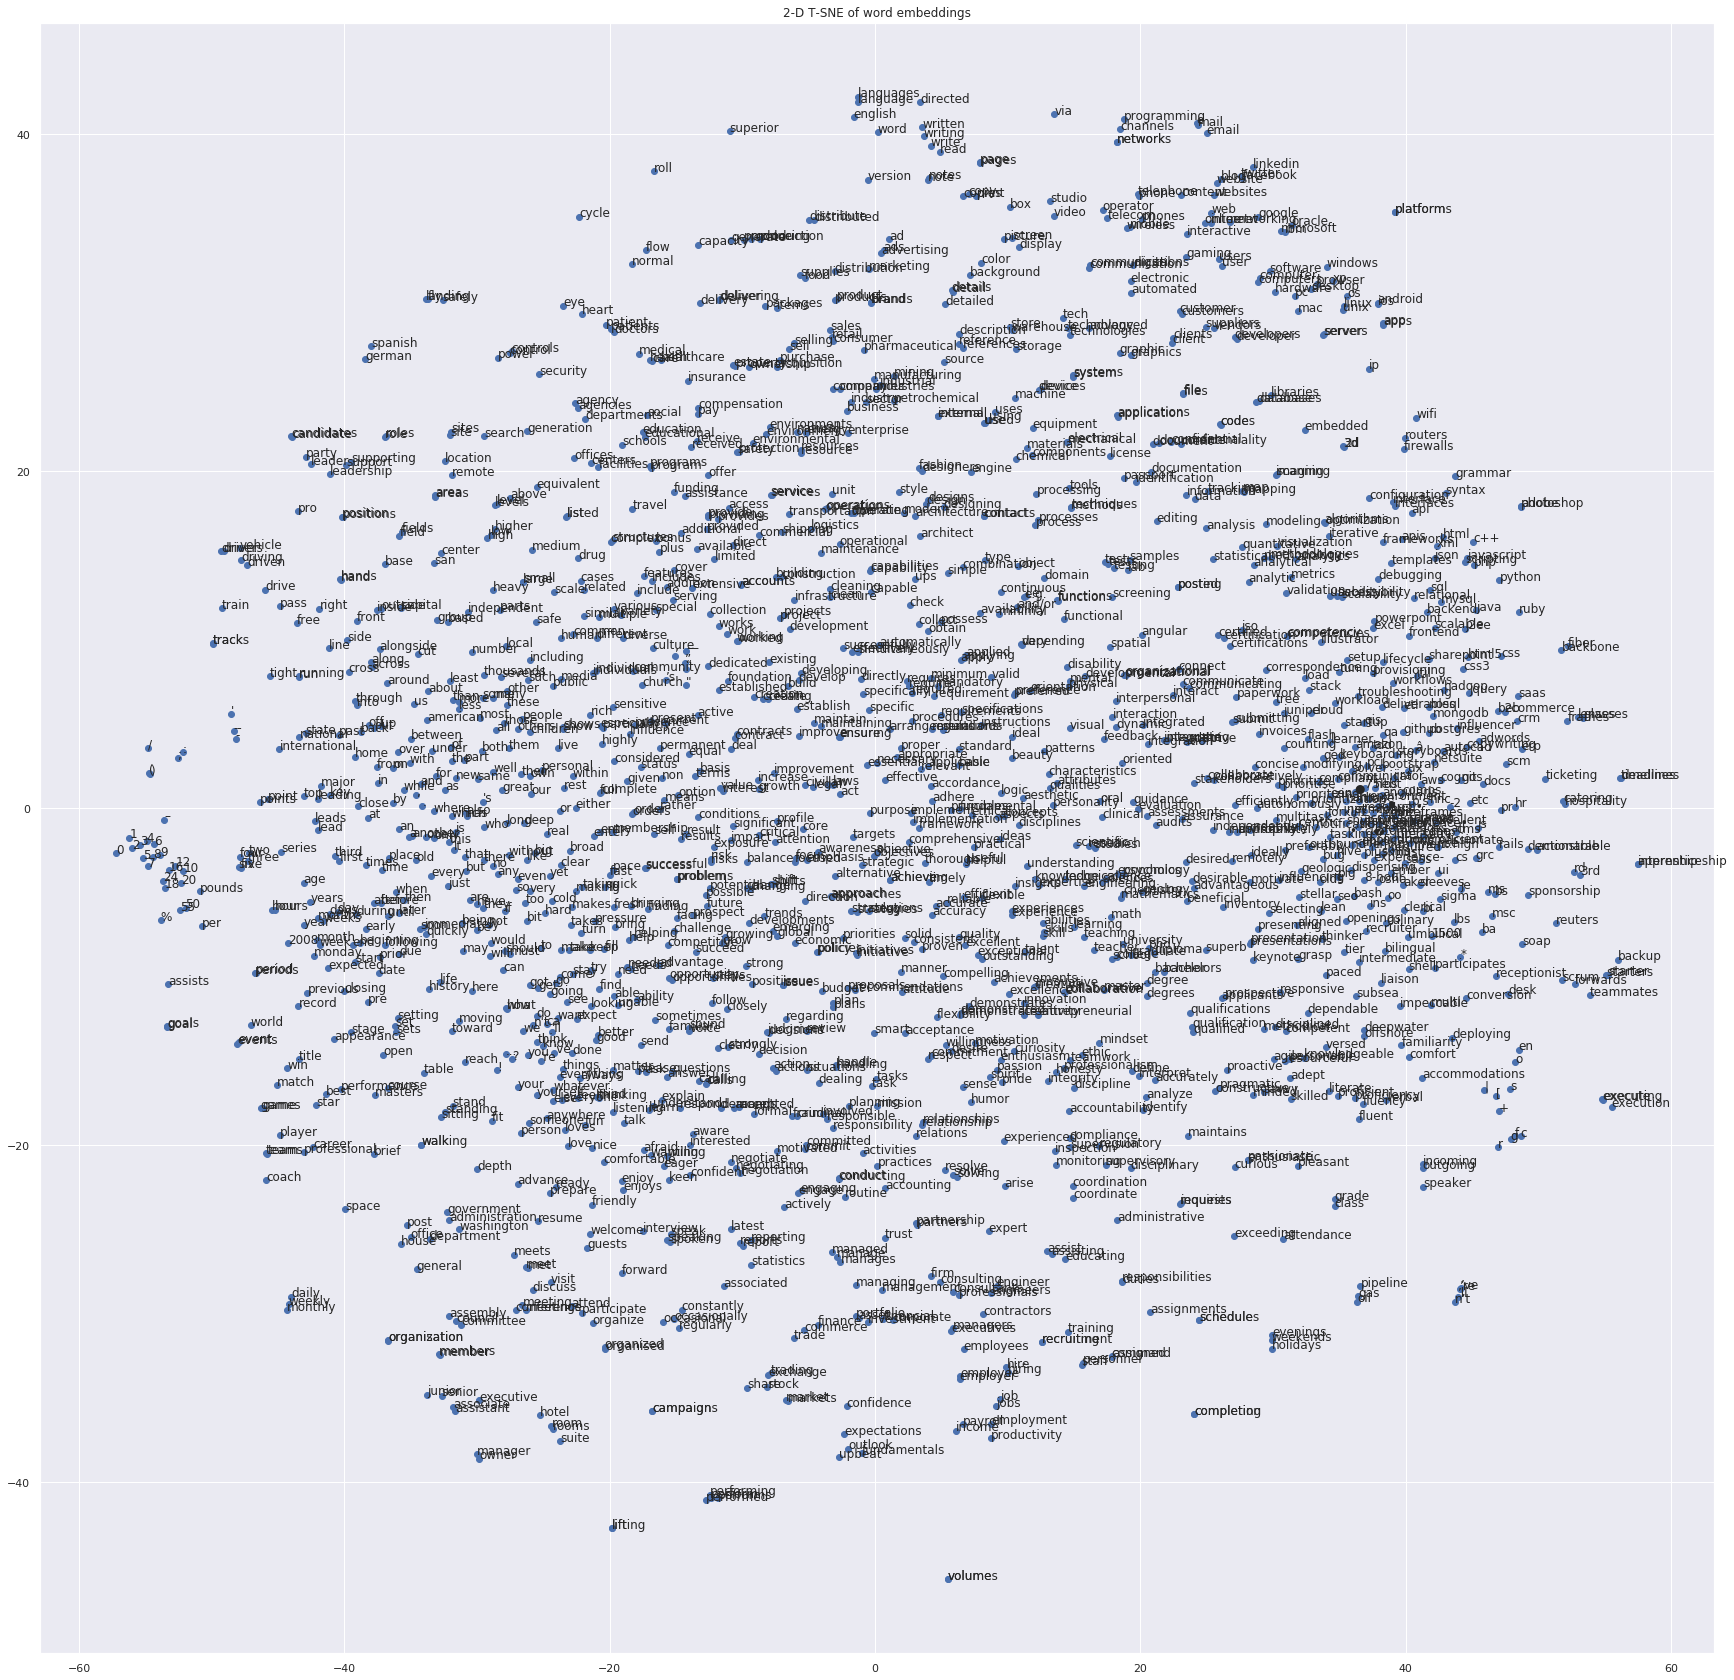

In [83]:
# Visualize
plt.rcParams["figure.figsize"] = (30,30)
plt.scatter(word_embed_vec2d[:,0],word_embed_vec2d[:,1])
plt.title("2-D T-SNE of word embeddings")
for i in range(len(word_embed_vec2d)):
    plt.annotate(TEXT.vocab.itos[i], (word_embed_vec2d[i,0], word_embed_vec2d[i,1]))
plt.show()

#### Testing on the unbalanced, full dataset

In [84]:
# testing on 15% of the whole dataset due to computational issues
url = "https://raw.githubusercontent.com/k-amini/NLP_RNN/master/clean_deduplicated_data/full_{}.csv".format(current_text_var)
data_test = pd.read_csv(url)
print("Datafile loaded!")
data_test = data_test.sample(frac = 0.15)

data_test['pred_proba'] = [predict(model, str(i)) for i in data_test[current_text_var]]

Datafile loaded!


In [0]:
# Sample and population probabilities
q1 = 659/(659+14436)
r1 = 586/2000 

# Reweight class prediction probability
data_test['pred_rew_proba'] = data_test['pred_proba'].apply(reweight,args=(q1,r1))
# Classification
data_test['pred_rew'] = [1 if data_test['pred_rew_proba'].iloc[i]>0.5 else 0 for i in range(0,len(data_test))]

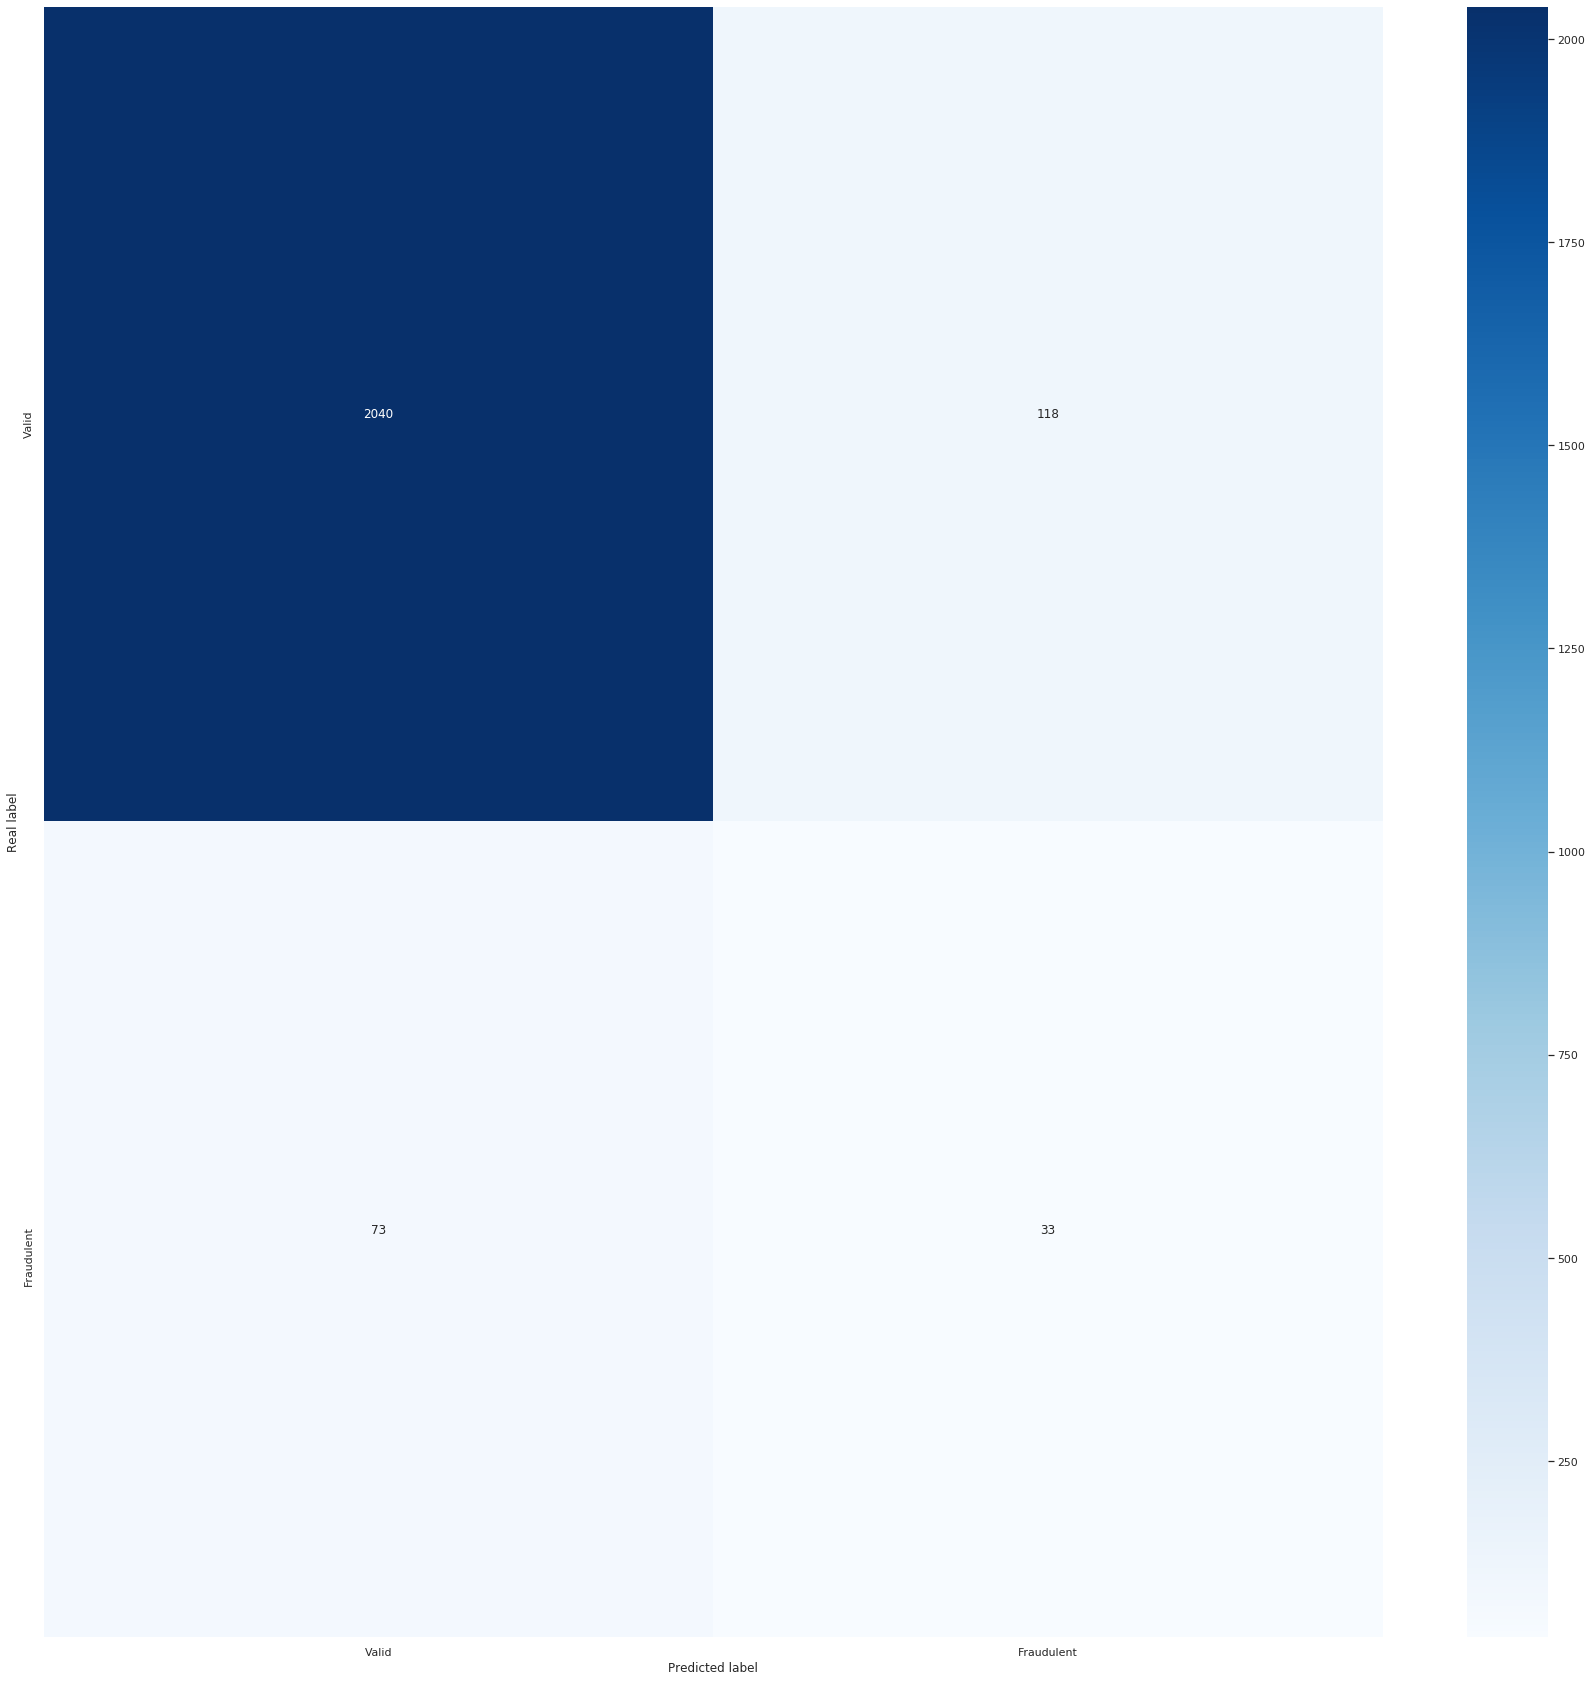

In [86]:
conf_matrix = confusion_matrix_builder(dataframe=data_test,
                                       true_colname='fraudulent',
                                       pred_colname='pred_rew')
# Print results
#print(conf_matrix)

# Plot results
plot_confusion_matrix(conf_matrix, class_labels=['Valid','Fraudulent'])

AUC:  0.7502251385804465


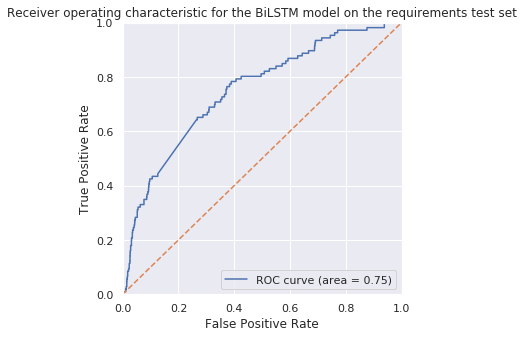

Accuracy score: 0.9156360424028268


In [87]:
# Convert target variable to numeric
data_test['fraudulent'] = [1 if i=='t' else 0 for i in data_test['fraudulent']]

get_auc(y=data_test['fraudulent'], y_pred_probabilities=data_test['pred_rew_proba'],
        class_labels=['Valid','Fraudulent'],
        column =1, plot = True)

acc_score = accuracy_score(data_test['fraudulent'],data_test['pred_rew'])
print("Accuracy score: {}".format(acc_score))

#### Testing on the study dataset

In [88]:
url = "https://raw.githubusercontent.com/k-amini/NLP_RNN/master/study_data/study_{}.csv".format(current_text_var)
data_test = pd.read_csv(url)
print("Datafile loaded!")
#data_test = data_test.sample(frac = 0.15)

data_test['pred_proba'] = [predict(model, str(i)) for i in data_test[current_text_var]]

Datafile loaded!


In [0]:
# Sample and population probabilities
q1 = 450/(450+450)
r1 = 586/2000 

# Reweight class prediction probability
data_test['pred_rew_proba'] = data_test['pred_proba'].apply(reweight,args=(q1,r1))
# Classification
data_test['pred_rew'] = [1 if data_test['pred_rew_proba'].iloc[i]>0.5 else 0 for i in range(0,len(data_test))]

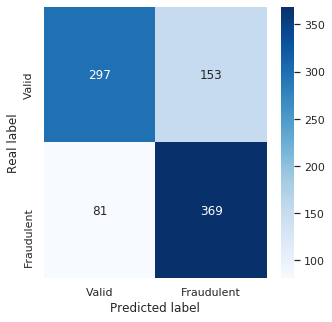

In [90]:
# Build confusion matrix
conf_matrix = confusion_matrix_builder(dataframe=data_test,
                                       true_colname='fraudulent',
                                       pred_colname='pred_rew')


# Plot results
plot_confusion_matrix(conf_matrix, class_labels=['Valid','Fraudulent'])

AUC:  0.7847654320987654


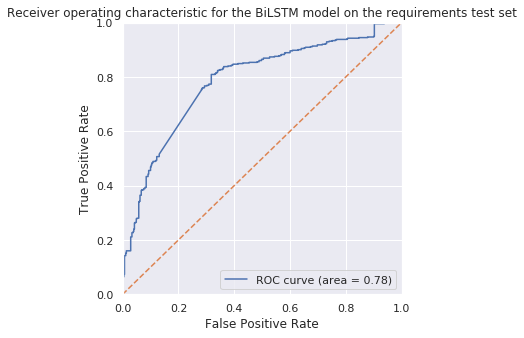

Accuracy score: 0.74


In [91]:
# Convert target variable to numeric
data_test['fraudulent'] = [1 if i=='t' else 0 for i in data_test['fraudulent']]

get_auc(y=data_test['fraudulent'], y_pred_probabilities=data_test['pred_rew_proba'],
        class_labels=['Valid','Fraudulent'],
        column =1, plot = True)

acc_score = accuracy_score(data_test['fraudulent'],data_test['pred_rew'])
print("Accuracy score: {}".format(acc_score))

# Diagnose misclassified cases

In [92]:
# Filter for misclassified observation
data_test_misclass = data_test[data_test['fraudulent']!=data_test['pred_rew']]

# Get current text variable
misclass_text = data_test_misclass[current_text_var]

# Display and inspect results
print(len(data_test_misclass))
display(data_test_misclass.head())

234


,fraudulent,requirements,pred_proba,pred_rew_proba,pred_rew
6,0,the international broadcaster shall properly c...,0.887640,0.950155,1
10,1,to be considered for this role you will have: ...,0.192514,0.365193,0
14,0,you will need at least 3 months of cash handli...,0.401126,0.617767,1
17,1,requirements all you need is access to the int...,0.018931,0.044489,0
18,1,requirements all you need is access to the int...,0.018931,0.044489,0


In [93]:
# Look at the text from some misclassified cases
display(list(misclass_text))

['the international broadcaster shall properly complete all daily tasks. these daily tasks include but are not limited to: preparing for assignments (fails not more than once per week); revising video packages (fails not more than twice per week); correcting production errors in stories (fails not more than twice per week); properly creating line-ups and logs (fails not more than once per week). knowledge of africa and somali language required.',
 'to be considered for this role you will have: daily cash reporting and cash flow forecast assisting ad-hoc monthly reports for management financial reporting other duties as required essential selection criteria: ability to work independently advanced user of excel (formulas and pivot tables) payroll knowledge would be an advantage excellent attention to detail ',
 "you will need at least 3 months of cash handling experience in either retail, casino's, betting shops or banking. you must be prepared to spend up to 6 months at a time away from